# imports

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import nltk, re, string
import sys, os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer


# Part 1

**Part 1 Question 1**

i) \
\
Currently the regex might remove to many special characters.

The regex used was:
text = re.sub(r'[^\w\s]', '', text)  

which effectively removes anything that is not a word or a white space.
The removal of punctuation by the above regex may be too much.

For example, in the dataset the line "john deere, john 3:16	2016" exists. With the regex applied, it would instead read
"john deere, john 316   2016". With the colon removed, the clear religious context of "john 3:16" is now "john 316" which has ambiguous meaning.

To fix this mistake, the regex can be modified to include punctuation, as demonstrated in the cell below.

In [ ]:
# include punctuation in regex pattern
text = "hello你好 !!123🗿 🤫🧏‍♂️ John 3:16"

import string
pattern = rf"[^\w\s{re.escape(string.punctuation)}]"  # modified regex pattern to include punctuation
text = re.sub(pattern, '', text)  
print(text)

hello你好 !!123  John 3:16


ii) \
\
K-Fold cross validation can be used instead of only one training-test split.

K-Fold CV divides the subset into *k subsets. Then, *k-1 subsets are used for training and the remaining subset is used for validation. In this method, the training is iterated *k times, with a different subset used for validation each time.

Stratified K-Fold is an additional type of K-Fold CV that ensures each "fold" of the dataset has the same proportion of observations with a given label. This helps in creating better class distribution accross folds.

Below is a code snippet that demonstrates the use of Stratified K-Fold CV in this assignment.

In [429]:

### non-working code. for demonstration only!! ###
print("##################################################")
print("THIS CODE BLOCK IS FOR DEMONSTRATION ONLY!!")
print("##################################################")

# assert(True == False)
# pipeline = make_pipeline(
#     TfidfVectorizer(),
#     BernoulliNB()    
# )

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# bnb_scores = cross_val_score(
#     pipeline,
#     df['content'],       # input features
#     df['topic'],         # labels
#     cv=cv,
#     scoring='accuracy'
# )

##################################################
THIS CODE BLOCK IS FOR DEMONSTRATION ONLY!!
##################################################


**Part 2 Question 2**

Data import and Pre-processing steps.

Best pre-processing steps:
- Lowercasing
- removal of special characters except punctuation
- removal of numbers
- tokenizing words
- filtering stop words
- lemmatizing words instead of stemming

In [3]:
#all common setup code.

df = pd.read_csv('dataset.tsv', sep='\t')
df = df.drop_duplicates()
df = df.dropna()

# concantenante

df['content'] = df['artist_name'].astype(str) + " " + df['track_name'].astype(str) + " " + df['genre'] + " " + df['lyrics']

# pre-processing

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))


df['original'] = df['content']  # keep original content for reference
def preprocess_text(text):
    text = text.lower()          # no impact
    pattern = rf"[^\w\s{re.escape(string.punctuation)}]"  # modified regex pattern to include punctuation (question 1)
    text = re.sub(pattern, '', text)  
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [WordNetLemmatizer().lemmatize(tok, pos='v') for tok in tokens]
    return ' '.join(tokens)

df['content'] = df['content'].apply(preprocess_text)

    


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/raymond/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/raymond/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/raymond/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/raymond/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Multinomial Naive Bayes method

In [4]:
mnb_pipeline = make_pipeline(
    TfidfVectorizer(),
    MultinomialNB()    
)

#define cross-validation strategy and scoring metrics
mnb_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mnb_scoring = {
    'accuracy'        : 'balanced_accuracy',  # you can still use the built-in string
    'precision_macro' : make_scorer(
        precision_score,
        average='macro',
        zero_division=0      # or 1, or 'warn'—your choice
    ),
    'f1_macro'        : make_scorer(
        f1_score,
        average='macro',
        zero_division=0      # ensures F1 handles any 0/0 in its internal precision/recall
    )
}

# Perform cross-validation
mnb_results = cross_validate(
    mnb_pipeline,
    df['content'],       # input features
    df['topic'],         # labels
    cv=mnb_cv,
    scoring=mnb_scoring,
    return_train_score=False
)

# Print the results for each metric
for metric in mnb_scoring:
    key = f"test_{metric}"
    mnb_scores = mnb_results[key]
    # print(f"Per-fold {key}:", mnb_scores)
    print(f"Mean {key}      :", np.mean(mnb_scores))

Mean test_accuracy      : 0.46983372182264793
Mean test_precision_macro      : 0.5256795592929449
Mean test_f1_macro      : 0.43918790848991895


no_lowercase     Mean accuracy: 0.470
stemming         Mean accuracy: 0.468
no_stop_words    Mean accuracy: 0.465
no_punctuation   Mean accuracy: 0.470
no_tokenize      Mean accuracy: 0.470
original         Mean accuracy: 0.470
no_digits        Mean accuracy: 0.470


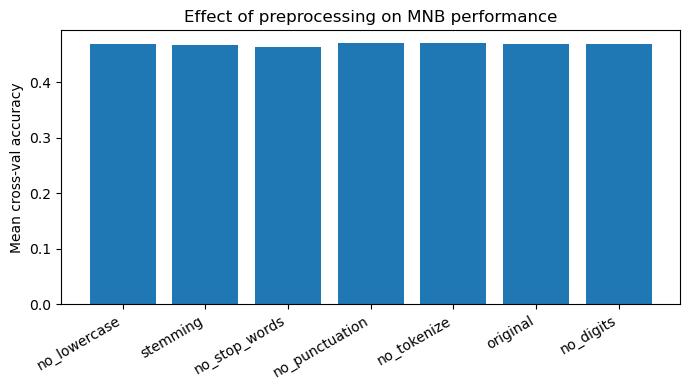

In [5]:
#try different preprocessing methods with default mnb.
def preprocess_text_no_text_lower(text):
    # text = text.lower()          # no impact
    pattern = rf"[^\w\s{re.escape(string.punctuation)}]"  # modified regex pattern to include punctuation (question 1)
    text = re.sub(pattern, '', text)  
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [WordNetLemmatizer().lemmatize(tok, pos='v') for tok in tokens]
    return ' '.join(tokens)

# stem words instead of lemmatizing
def preprocess_text_stem_words(text):
    text = text.lower()          # no impact
    pattern = rf"[^\w\s{re.escape(string.punctuation)}]"  # modified regex pattern to include punctuation (question 1)
    text = re.sub(pattern, '', text)  
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

# no stop words
def preprocess_text_no_stop_words(text):
    text = text.lower()          # no impact
    pattern = rf"[^\w\s{re.escape(string.punctuation)}]"  # modified regex pattern to include punctuation (question 1)
    text = re.sub(pattern, '', text)  
    tokens = word_tokenize(text)
    tokens = [WordNetLemmatizer().lemmatize(tok, pos='v') for tok in tokens]
    return ' '.join(tokens)

# removes punctuation
def preprocess_text_no_punctuation(text):
    text = text.lower()          # no impact
    pattern = rf"[^\w\s]"  # modified regex pattern to remove punctuation
    text = re.sub(pattern, '', text)  
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [WordNetLemmatizer().lemmatize(tok, pos='v') for tok in tokens]
    return ' '.join(tokens)

# do not tokenize words
def preprocess_text_no_tokenize(text):
    text = text.lower()          # no impact
    pattern = rf"[^\w\s{re.escape(string.punctuation)}]"  # modified regex pattern to include punctuation (question 1)
    text = re.sub(pattern, '', text)  
    tokens = [word for word in text.split() if word not in stop_words]
    tokens = [WordNetLemmatizer().lemmatize(tok, pos='v') for tok in tokens]
    return ' '.join(tokens)

#strip digits
def preprocess_text_no_digits(text):
    """
    Same pipeline as preprocess_text, but also strips out any digits (0-9).
    """
    text = text.lower()

    # First remove digits explicitly
    text = re.sub(r"\d+", "", text)          # drop all numeric characters

    # Then remove any other unwanted symbols (keeps words, whitespace, punctuation)
    pattern = rf"[^\w\s{re.escape(string.punctuation)}]"
    text = re.sub(pattern, "", text)

    # Tokenise and clean
    tokens = word_tokenize(text)
    tokens = [tok for tok in tokens if tok not in stop_words]
    tokens = [WordNetLemmatizer().lemmatize(tok, pos="v") for tok in tokens]

    return " ".join(tokens)


preprocess_variants = {
    "no_lowercase"  : preprocess_text_no_text_lower,
    "stemming"      : preprocess_text_stem_words,
    "no_stop_words" : preprocess_text_no_stop_words,
    "no_punctuation": preprocess_text_no_punctuation,
    "no_tokenize"   : preprocess_text_no_tokenize,
    "original"      : preprocess_text,
    "no_digits"     : preprocess_text_no_digits
}

# 2) Evaluate each preprocessing method using mnb and CV.
mean_acc = {}
for name, func in preprocess_variants.items():
    X = df['original'].apply(func)
    cv_res = cross_validate(
        mnb_pipeline,
        X,
        df['topic'],
        cv=mnb_cv,
        scoring=mnb_scoring,       # must include "accuracy"
        return_train_score=False
    )
    mean_acc[name] = np.mean(cv_res["test_accuracy"])
    print(f"{name:15s}  Mean accuracy: {mean_acc[name]:.3f}")

# 3) Bar plot of mean accuracies
plt.figure(figsize=(7,4))
plt.bar(range(len(mean_acc)), list(mean_acc.values()), tick_label=list(mean_acc.keys()))
plt.ylabel("Mean cross-val accuracy")
plt.title("Effect of preprocessing on MNB performance")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

In the above cell modifications were made to assess the impact of changes, such as skipping the tokenize stage or using stemming instead of lemmatizing. It was found that factors such as keeping/removing the punctuation, keeping/removing digits, lowercasing or tokenizing had negligible impact on the performance. There was an observable performance difference when stemming was used instead of lemmatization, and when stop words were not removed. 

It was validated that the method described at the start of this question was equal or better to other assessed options.

**Question 3)**

Bernoulli Naive Bayes method

In [6]:
bnb_pipeline = make_pipeline(
    TfidfVectorizer(),
    BernoulliNB()    
)

# define cross-validation strategy and scoring metrics
bnb_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
bnb_scoring = {
    'accuracy'        : 'balanced_accuracy',  # you can still use the built-in string
    'precision_macro' : make_scorer(
        precision_score,
        average='macro',
        zero_division=0      # or 1, or 'warn'—your choice
    ),
    'f1_macro'        : make_scorer(
        f1_score,
        average='macro',
        zero_division=0      # ensures F1 handles any 0/0 in its internal precision/recall
    )
}

# Perform cross-validation for BernoulliNB
bnb_results = cross_validate(
    bnb_pipeline,
    df['content'],       # input features
    df['topic'],         # labels
    cv=bnb_cv,
    scoring=bnb_scoring,
    return_train_score=False
)

# Print the results for each metric for BernoulliNB
for metric in bnb_scoring:
    key = f"test_{metric}"
    bnb_scores = bnb_results[key]
    # print(f"Per-fold {key}:", bnb_scores)
    print(f"Mean {key}      :", np.mean(bnb_scores))

Mean test_accuracy      : 0.38483308268247757
Mean test_precision_macro      : 0.35398432722673523
Mean test_f1_macro      : 0.33619197014798285


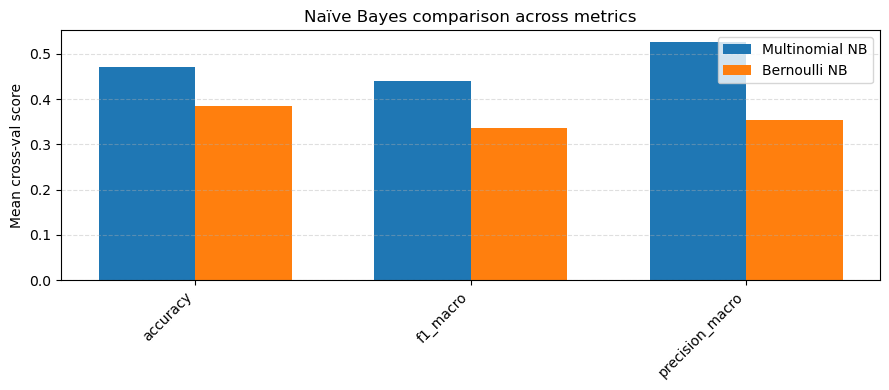

In [ ]:
#plot out the results for both MultinomialNB and BernoulliNB
metrics = sorted(set(mnb_scoring) | set(bnb_scoring))
mnb_means = [np.mean(mnb_results[f"test_{m}"]) for m in metrics]
bnb_means = [np.mean(bnb_results[f"test_{m}"]) for m in metrics]
x     = np.arange(len(metrics))
width = 0.35
fig, ax = plt.subplots(figsize=(9, 4))
ax.bar(x - width/2, mnb_means, width, label='Multinomial NB')
ax.bar(x + width/2, bnb_means, width, label='Bernoulli NB')
ax.set_ylabel('Mean cross-val score')
ax.set_title('Naïve Bayes comparison across metrics')
ax.set_xticks(x, metrics, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [8]:
#assessing the balance of the dataset.
counts = df['topic'].value_counts()
print(counts)

topic
dark         487
sadness      371
personal     341
lifestyle    202
emotion       79
Name: count, dtype: int64



Metrics were picked based on this being a multiple class classification problem.

- The balance of the class is assessed.
As the balance is off (dark has 487 whilst emotion has 79), a possible solutions is to instead use a macro-average of the metrics to account for multiple-classes. This approach gives higher than normal influence to dominated (smaller) classes. Smaller classes are still important as a lower number of songs does not neccessarily mean that topic has a lower number of users.

- Appropriate metrics: Precision, Recall, F1, Accuracy


    1. Macro Precision: 
Macro-precision is useful when false positives are costly. 

    2. Macro Recall / balanced accuracy  (they are the same thing):
Used when the coverage of each class is important. Helps to neutralise class imbalance even more as it rewards minority classes.

    3. Macro F1: Harmonic mean of Precision and Recall.
    Useful when using one metric, but both coverage and having minimal false positives are important.

-Tradeoffs:
There is a tradeoff between precision and recall. Prioritising recall is likely to reduce precision, whilst prioritising precision is likely to reduce recall. 

- Therefore, balanced_accuracy(macro recall), and macro-f1, macro-precision was used as the main metrics. Accuracy for parts 1 and 2 will refer to macro recall.


An overall comparison of BNB and MNB found that MNB was superior. It had both better accuracy/recall and precision.

**Question 4)**

Gridsearch through top N words.

In [9]:
#gridsearch through bnb.
feature_limits = [1, 5, 10, 100, 325, 350, 375, 500, 1000, 10000]
bnb_results_df = pd.DataFrame({
    'Feature Limit': feature_limits,
    'accuracy': [0.0 for _ in feature_limits],
    'precision_macro': [0.0 for _ in feature_limits],
    'f1_macro': [0.0 for _ in feature_limits],
})

#execute grid search on bnb
for limit in feature_limits:
    bnb_pipeline = make_pipeline(
        TfidfVectorizer(max_features=limit),
        BernoulliNB()
    )
    bnb_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    bnb_results = cross_validate(
        bnb_pipeline,
        df['content'],       # input features
        df['topic'],         # labels
        cv=bnb_cv,
        scoring=bnb_scoring,
        return_train_score=False
    )
    # print(f"Max features: {limit}")
    for metric in bnb_scoring:
        key = f"test_{metric}"
        bnb_scores = bnb_results[key]
        bnb_results_df.loc[bnb_results_df['Feature Limit'] == limit, metric] = np.mean(bnb_scores)
        # print(f"Mean {key}      :", np.mean(bnb_scores))


In [10]:
#gridsearch through mnb
feature_limits = [1, 5, 10, 100, 325, 350, 375, 500, 1000, 10000]
mnb_results_df = pd.DataFrame({
    'Feature Limit': feature_limits,
    'accuracy': [0.0 for _ in feature_limits],
    'precision_macro': [0.0 for _ in feature_limits],
    'f1_macro': [0.0 for _ in feature_limits],
})

#execute gridsearch on mnb
for limit in feature_limits:
    mnb_pipeline = make_pipeline(
        TfidfVectorizer(max_features=limit),
        MultinomialNB()
    )
    mnb_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    mnb_results = cross_validate(
        mnb_pipeline,
        df['content'],       # input features
        df['topic'],         # labels
        cv=mnb_cv,
        scoring=mnb_scoring,
        return_train_score=False
    )
    # print(f"Max features: {limit}")
    for metric in mnb_scoring:
        key = f"test_{metric}"
        mnb_scores = mnb_results[key]
        mnb_results_df.loc[mnb_results_df['Feature Limit'] == limit, metric] = np.mean(mnb_scores)
        # print(f"Mean {key}      :", np.mean(mnb_scores))

MultinomialNB Gridsearch Raw Results:
   Feature Limit  accuracy  precision_macro  f1_macro
0              1  0.200000         0.065811  0.099034
1              5  0.205301         0.119884  0.124552
2             10  0.326951         0.339862  0.305387
3            100  0.572495         0.732112  0.589119
4            325  0.649340         0.749404  0.654376
5            350  0.646663         0.709775  0.647626
6            375  0.644061         0.709187  0.644757
7            500  0.633002         0.670559  0.631508
8           1000  0.585905         0.653998  0.579244
9          10000  0.469834         0.525680  0.439188


BernoulliNB Gridsearch Raw Results:
   Feature Limit  accuracy  precision_macro  f1_macro
0              1  0.207040         0.090140  0.123347
1              5  0.226080         0.185065  0.182712
2             10  0.323355         0.278663  0.295077
3            100  0.497854         0.529942  0.506722
4            325  0.556561         0.566924  0.558029
5     

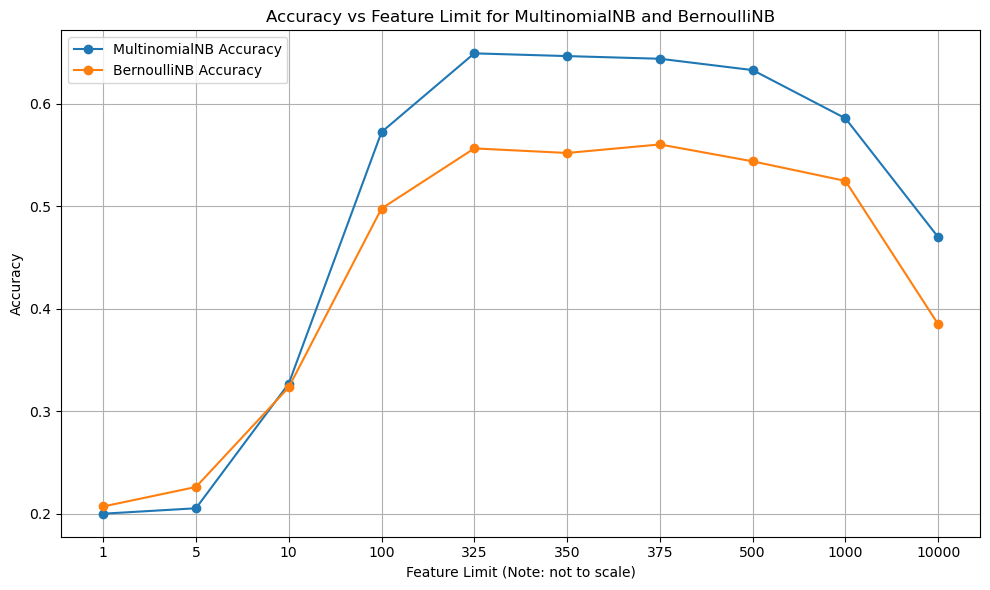

In [11]:
#plot out mnb vs bnb gridsearch results
print("MultinomialNB Gridsearch Raw Results:")
print(mnb_results_df)
print("\n")
print("BernoulliNB Gridsearch Raw Results:")
print(bnb_results_df)
# plotting feature limits against accuracy
plt.figure(figsize=(10, 6))
plt.plot(mnb_results_df['Feature Limit'].astype(str), mnb_results_df['accuracy'], marker='o', label='MultinomialNB Accuracy')
plt.plot(bnb_results_df['Feature Limit'].astype(str), bnb_results_df['accuracy'], marker='o', label='BernoulliNB Accuracy')
plt.xlabel('Feature Limit (Note: not to scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Feature Limit for MultinomialNB and BernoulliNB')
plt.legend()
plt.grid()
plt.tight_layout()

Through a gridsearch, it was found that each model performed best at about N=~350. The performance was vastly superior to N=inf (which is the default setting.)

N=350 is used as the feature number.

**Question 5)**

Other machine learning method (Support Vector machine SVM selected)

SVMs separate classes by forming a decision boundary (hyperplane) in the feature space that seeks to maximise the margin between two classifications.

A margin is the distance between the decision boundary and the closest data-points in each class. The data-points closest to the decision boundary are also known as the "support vectors". These closest-datapoints then define the boundary between two classes.

SVMs are suitable for classification over vectorized words. Vectorized words are typically sparse and high-dimensional. SVMs are good for this task because they only focus on a few key points which is much more computationally efficient that other methods that account for all datapoints, such as K-NNs. Flexible kernels that support sparse feature spaces additionally help to ensure good performance. Additionally, optimizations in embedding methods such as TF-IDF means that semantically similar words end up closer to each other compared to dissimilar words. This feature common to many word-vectorization method naturally forms clusters between similar words and spatial relationships (e.g. king - queen ~= man - woman) which lends themselves to natural and effective decision boundaries that can be identified by a SVM.

A SVM is primarily tunable through three parameters. The type of decision boundary / kernel (linear, polynomial etc), C: the penalty term for misclassifying points, and γ: which influences the flexibility of the decision boundary. A basic gridsearch will be performed over these parameters to find the best ones.

Due to the reasons presented above, it is hypothesised that the SVM would be much better than the MNB and BNB. This is because the SVM utilises and real-valued feature weights extracted by vectorization, as well as optimizations involved in TF-IDF vectorization. Conversely, the MNB and BNB instead relies on probabilistic calculations related to binary presence/absence or raw word counts. This approach by the MNB and BNB means that it is simply using much less information to make it's decisions, failing to leverage the rich features extracted by optimised vectorization methods such as TF-IDF.

In [12]:
# performing gridsearch on SVM to find optimal parameters

svm_pipeline = make_pipeline(
    TfidfVectorizer(max_features=350),
    SVC()    
)

svm_param_grid = [
    # For linear kernel we only need C
    {
        'svc__kernel': ['linear'],
        'svc__C':      [0.1, 1, 10, 100]
    },
    # For RBF, poly, sigmoid we also tune gamma
    {
        'svc__kernel': ['rbf', 'poly', 'sigmoid'],
        'svc__C':      [0.1, 1, 10, 100],
        'svc__gamma':  ['scale', 'auto', 0.001, 0.01, 0.1, 1]
    }
]

svm_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    cv=svm_cv,
    scoring='accuracy',
    n_jobs=-1,            # parallelize across cores if you like
    verbose=1
)

svm_grid.fit(df['content'], df['topic'])

print("Best params :", svm_grid.best_params_)
print("Best score  :", svm_grid.best_score_)

Fitting 5 folds for each of 76 candidates, totalling 380 fits
Best params : {'svc__C': 10, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
Best score  : 0.8783783783783784


In [ ]:
# fitting SVM model based on the best parameters found in grid search
svm_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline = make_pipeline(
    TfidfVectorizer(max_features=350),
    SVC(kernel='rbf', C=10, gamma='scale')  # using best params from grid search
)
pipeline.fit(df['content'], df['topic'])
svm_scoring = mnb_scoring  # reusing the same scoring metrics
svm_results = cross_validate(
    pipeline,
    df['content'],       # input features
    df['topic'],         # labels
    cv=svm_cv,
    scoring=svm_scoring,
    return_train_score=False
)
for metric in svm_scoring:
    key = f"test_{metric}"
    svm_scores = svm_results[key]
    print(f"Mean {key}      :", np.mean(svm_scores))

svm_model = pipeline


Mean test_accuracy      : 0.8577657013503703
Mean test_precision_macro      : 0.878426542835359
Mean test_f1_macro      : 0.8662559245095492


My hypothesis regarding SVMs was correct, in that it was very effective in classifying words. MNB and BNB accuracy peaked at around 0.649 and 0.560 respectively, whilst SVM was able to achieve a significantly higher accuracy of 0.8577. Other metrics yielded similar results.

Therefore, the "best" method was the SVM, with settings " kernel='rbf', C=10, gamma='scale' "

# Part 2

**Question 1**

In [ ]:
#load dataset for question 2
import sklearn.model_selection


df2 = pd.read_csv('dataset.tsv', sep='\t')
df2['content'] = df2['artist_name'].astype(str) + " " + df2['track_name'].astype(str) + " " + df2['genre'] + " " + df2['lyrics']
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))
stop_words2 = set(stopwords.words('english'))
custom = {'come', 'like', 'yeah'}          # put any others here
stop_words2.update(custom)                  # now they’re treated as stop-words

df2['content'] = df2['content'].apply(preprocess_text)

print(df2['content'].head())

# make train test split, and fit vectorizer on training data to generate vocabulary
q2train, q2test = sklearn.model_selection.train_test_split(df2['content'], train_size=750, test_size=750, shuffle=False)
q2vectorizer = TfidfVectorizer(max_features=350)

q2vectorizer.fit(q2train)   #set vocabulary


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/raymond/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/raymond/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/raymond/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/raymond/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    love real lake rock awake know go see time cle...
1    incubus summer rock summer pretty build spill ...
2    reignwolf hardcore blue lose deep catch breath...
3    tedeschi truck band anyhow blue run bitter tas...
4    lukas nelson promise real start blue think thi...
Name: content, dtype: object


TfidfVectorizer(max_features=350)

create 5 vectors and matrices, one for each topic where each song "document" has a vector.

In [ ]:
# sort the training data by topic
topic_predict = svm_model.predict(q2train)
df3 = pd.DataFrame()
df3['predictions'] = topic_predict
counts = df3['predictions'].value_counts()    
print(counts)
dark_raw = [document for idx, document in enumerate(q2train) if topic_predict[idx] == 'dark']
sadness_raw = [document for idx, document in enumerate(q2train) if topic_predict[idx] == 'sadness']
personal_raw = [document for idx, document in enumerate(q2train) if topic_predict[idx] == 'personal']
lifestyle_raw = [document for idx, document in enumerate(q2train) if topic_predict[idx] == 'lifestyle']
emotion_raw = [document for idx, document in enumerate(q2train) if topic_predict[idx] == 'emotion']

# transform the raw data into vectors using the fitted vectorizer
dark = q2vectorizer.transform(dark_raw)
sadness = q2vectorizer.transform(sadness_raw)
personal = q2vectorizer.transform(personal_raw)
lifestyle = q2vectorizer.transform(lifestyle_raw)
emotion = q2vectorizer.transform(emotion_raw)

print("Dark shape      :", dark.shape)
print("Sadness shape   :", sadness.shape)
print("Personal shape  :", personal.shape)
print("Lifestyle shape :", lifestyle.shape)
print("Emotion shape   :", emotion.shape)

predictions
dark         246
personal     188
sadness      182
lifestyle     92
emotion       42
Name: count, dtype: int64
Dark shape      : (246, 350)
Sadness shape   : (182, 350)
Personal shape  : (188, 350)
Lifestyle shape : (92, 350)
Emotion shape   : (42, 350)


User 1 profile:

In [19]:
############
# for each topic, vectorize the songs that match the user's keywords.
# this represents the user's profile for that topic.
############
df_user1 = pd.read_csv('user1.tsv', sep='\t')
user1_dark_kw_str = df_user1['keywords'][0].split(',')  # assuming keywords are comma-separated
for idx, kw in enumerate(user1_dark_kw_str):
    user1_dark_kw_str[idx] = preprocess_text(kw)
dark_user1 = [document for document in dark_raw if any(kw in document for kw in user1_dark_kw_str)]
dark_user1_str = " ".join(dark_user1).splitlines()  # join the list into a single string for display
user1_dark_profile = q2vectorizer.transform(dark_user1_str)

user1_sadness_kw_str = df_user1['keywords'][1].split(',')  # assuming keywords are comma-separated
for idx, kw in enumerate(user1_sadness_kw_str):
    user1_sadness_kw_str[idx] = preprocess_text(kw)
sadness_user1 = [document for document in sadness_raw if any(kw in document for kw in user1_sadness_kw_str)]
sadness_user1_str = " ".join(sadness_user1).splitlines()  # join the list into a single string for display
user1_sadness_profile = q2vectorizer.transform(sadness_user1_str)

user1_personal_kw_str = df_user1['keywords'][2].split(',')  # assuming keywords are comma-separated
for idx, kw in enumerate(user1_personal_kw_str):
    user1_personal_kw_str[idx] = preprocess_text(kw)
personal_user1 = [document for document in personal_raw if any(kw in document for kw in user1_personal_kw_str)]
personal_user1_str = " ".join(personal_user1).splitlines()  # join the list into a single string for display
user1_personal_profile = q2vectorizer.transform(personal_user1_str)

user1_lifestyle_kw_str = df_user1['keywords'][3].split(',')  # assuming keywords are comma-separated
for idx, kw in enumerate(user1_lifestyle_kw_str):
    user1_lifestyle_kw_str[idx] = preprocess_text(kw)
lifestyle_user1 = [document for document in lifestyle_raw if any(kw in document for kw in user1_lifestyle_kw_str)]
lifestyle_user1_str = " ".join(lifestyle_user1).splitlines()  # join the list into a single string for display
user1_lifestyle_profile = q2vectorizer.transform(lifestyle_user1_str)

user1_emotion_kw_str = df_user1['keywords'][4].split(',')  # assuming keywords are comma-separated
for idx, kw in enumerate(user1_emotion_kw_str):
    user1_emotion_kw_str[idx] = preprocess_text(kw)
emotion_user1 = [document for document in emotion_raw if any(kw in document for kw in user1_emotion_kw_str)]
emotion_user1_str = " ".join(emotion_user1).splitlines()  # join the list into a single string for display
user1_emotion_profile = q2vectorizer.transform(emotion_user1_str)

############
# get top 20 terms for each topic based on the user's profile.
############

user1_dark_profile = user1_dark_profile.mean(axis=0).A1            # mean over one sample is itself.
darktop20_idx   = user1_dark_profile.argsort()[::-1][:20]   
feature_names = np.array(q2vectorizer.get_feature_names_out())
darktop20_terms   = feature_names[darktop20_idx]
darktop20_scores  = user1_dark_profile[darktop20_idx]
print("=== Dark Top 20 Terms ===")
for term, score in zip(darktop20_terms, darktop20_scores):
    print(f"{term:<15s} {score:.4f}")

user1_sadness_profile = user1_sadness_profile.mean(axis=0).A1            # mean over one sample is itself.
sadnesstop20_idx   = user1_sadness_profile.argsort()[::-1][:20]   
feature_names = np.array(q2vectorizer.get_feature_names_out())
sadnesstop20_terms   = feature_names[sadnesstop20_idx]
sadnesstop20_scores  = user1_sadness_profile[sadnesstop20_idx]
print("=== Sadness Top 20 Terms ===")
for term, score in zip(sadnesstop20_terms, sadnesstop20_scores):
    print(f"{term:<15s} {score:.4f}")

user1_personal_profile = user1_personal_profile.mean(axis=0).A1            # mean over one sample is itself.
personaltop20_idx   = user1_personal_profile.argsort()[::-1][:20]   
feature_names = np.array(q2vectorizer.get_feature_names_out())
personaltop20_terms   = feature_names[personaltop20_idx]
personaltop20_scores  = user1_personal_profile[personaltop20_idx]
print("=== Personal Top 20 Terms ===")
for term, score in zip(personaltop20_terms, personaltop20_scores):
    print(f"{term:<15s} {score:.4f}")

user1_lifestyle_profile = user1_lifestyle_profile.mean(axis=0).A1            # mean over one sample is itself.
lifestyletop20_idx   = user1_lifestyle_profile.argsort()[::-1][:20]   
feature_names = np.array(q2vectorizer.get_feature_names_out())
lifestyletop20_terms   = feature_names[lifestyletop20_idx]
lifestyletop20_scores  = user1_lifestyle_profile[lifestyletop20_idx]
print("=== Lifestyle Top 20 Terms ===")
for term, score in zip(lifestyletop20_terms, lifestyletop20_scores):
    print(f"{term:<15s} {score:.4f}")

user1_emotion_profile = user1_emotion_profile.mean(axis=0).A1            # mean over one sample is itself.
emotiontop20_idx   = user1_emotion_profile.argsort()[::-1][:20]   
feature_names = np.array(q2vectorizer.get_feature_names_out())
emotiontop20_terms   = feature_names[emotiontop20_idx]
emotiontop20_scores  = user1_emotion_profile[emotiontop20_idx]
print("=== Emotion Top 20 Terms ===")
for term, score in zip(emotiontop20_terms, emotiontop20_scores):
    print(f"{term:<15s} {score:.4f}")

=== Dark Top 20 Terms ===
fight           0.3571
black           0.2188
blood           0.2122
grind           0.2011
stand           0.1729
know            0.1651
come            0.1621
like            0.1560
kill            0.1432
na              0.1407
gon             0.1349
tell            0.1333
hand            0.1214
head            0.1155
yeah            0.1127
follow          0.1104
build           0.1074
death           0.1016
bone            0.0996
paint           0.0993
=== Sadness Top 20 Terms ===
tear            0.3734
cry             0.3482
away            0.1975
na              0.1931
woah            0.1885
baby            0.1867
break           0.1811
know            0.1662
heart           0.1657
hurt            0.1535
steal           0.1453
fall            0.1392
gon             0.1332
fade            0.1302
place           0.1296
apart           0.1262
want            0.1261
feel            0.1247
think           0.1205
wish            0.1191
=== Personal Top 20 Terms

User 2.

In [20]:
############
# for each topic, vectorize the songs that match the user's keywords.
# this represents the user's profile for that topic.
############

df_user2 = pd.read_csv('user2.tsv', sep='\t')


user2_sadness_kw_str = df_user2['keywords'][0].split(',')  # assuming keywords are comma-separated
for idx, kw in enumerate(user2_sadness_kw_str):
    user2_sadness_kw_str[idx] = preprocess_text(kw)
sadness_user2 = [document for document in sadness_raw if any(kw in document for kw in user2_sadness_kw_str)]
sadness_user2_str = " ".join(sadness_user2).splitlines()  # join the list into a single string for display
user2_sadness_profile = q2vectorizer.transform(sadness_user2_str)

user2_emotion_kw_str = df_user2['keywords'][1].split(',')  # assuming keywords are comma-separated
for idx, kw in enumerate(user2_emotion_kw_str):
    user2_emotion_kw_str[idx] = preprocess_text(kw)
emotion_user2 = [document for document in emotion_raw if any(kw in document for kw in user2_emotion_kw_str)]
emotion_user2_str = " ".join(emotion_user2).splitlines()  # join the list into a single string for display
user2_emotion_profile = q2vectorizer.transform(emotion_user2_str)

############
# get top 20 terms for each topic based on the user's profile.
############

user2_sadness_profile = user2_sadness_profile.mean(axis=0).A1            # mean over one sample is itself.
sadnesstop20_idx   = user2_sadness_profile.argsort()[::-1][:20]   
feature_names = np.array(q2vectorizer.get_feature_names_out())
sadnesstop20_terms   = feature_names[sadnesstop20_idx]
sadnesstop20_scores  = user2_sadness_profile[sadnesstop20_idx]
print("=== Sadness Top 20 Terms ===")
for term, score in zip(sadnesstop20_terms, sadnesstop20_scores):
    print(f"{term:<15s} {score:.4f}")

user2_emotion_profile = user2_emotion_profile.mean(axis=0).A1          # mean over one sample is itself.
emotiontop20_idx   = user2_emotion_profile.argsort()[::-1][:20]   
feature_names = np.array(q2vectorizer.get_feature_names_out())
emotiontop20_terms   = feature_names[emotiontop20_idx]
emotiontop20_scores  = user2_emotion_profile[emotiontop20_idx]
print("=== Emotion Top 20 Terms ===")
for term, score in zip(emotiontop20_terms, emotiontop20_scores):
    print(f"{term:<15s} {score:.4f}")

=== Sadness Top 20 Terms ===
heart           0.2938
away            0.2630
break           0.2574
fall            0.2037
hurt            0.1971
na              0.1918
tear            0.1839
know            0.1637
think           0.1526
baby            0.1520
wan             0.1460
leave           0.1448
inside          0.1431
apart           0.1272
feel            0.1198
yeah            0.1147
fade            0.1143
step            0.1127
cry             0.1124
cause           0.1111
=== Emotion Top 20 Terms ===
good            0.6757
touch           0.4046
feel            0.3241
hold            0.1975
vibe            0.1301
feelin          0.1300
kiss            0.1268
know            0.1252
morning         0.1228
miss            0.1157
luck            0.1110
go              0.1052
want            0.0977
lips            0.0914
baby            0.0795
real            0.0784
na              0.0702
light           0.0625
like            0.0607
cause           0.0607


User 3

In [21]:
############
# for each topic, vectorize the songs that match the user's keywords.
# this represents the user's profile for that topic.
############

df_user3 = pd.DataFrame(
    {
        "topic": ["dark", "personal", "emotion"],
        "keywords": [
            "blood",
            "live, life, discover, fate",
            "feel, good, babe",
        ],
    }
)

user3_dark_kw_str = df_user3['keywords'][0].split(',')  # assuming keywords are comma-separated
for idx, kw in enumerate(user3_dark_kw_str):
    user3_dark_kw_str[idx] = preprocess_text(kw)
dark_user3 = [document for document in dark_raw if any(kw in document for kw in user3_dark_kw_str)]
dark_user3_str = " ".join(dark_user3).splitlines()  # join the list into a single string for display
user3_dark_profile = q2vectorizer.transform(dark_user3_str)

user3_personal_kw_str = df_user3['keywords'][0].split(',')  # assuming keywords are comma-separated
for idx, kw in enumerate(user3_personal_kw_str):
    user3_personal_kw_str[idx] = preprocess_text(kw)
personal_user3 = [document for document in personal_raw if any(kw in document for kw in user3_personal_kw_str)]
personal_user3_str = " ".join(personal_user3).splitlines()  # join the list into a single string for display
user3_personal_profile = q2vectorizer.transform(personal_user3_str)

user3_emotion_kw_str = df_user3['keywords'][1].split(',')  # assuming keywords are comma-separated
for idx, kw in enumerate(user3_emotion_kw_str):
    user3_emotion_kw_str[idx] = preprocess_text(kw)
emotion_user3 = [document for document in emotion_raw if any(kw in document for kw in user3_emotion_kw_str)]
emotion_user3_str = " ".join(emotion_user3).splitlines()  # join the list into a single string for display
user3_emotion_profile = q2vectorizer.transform(emotion_user3_str)

############
# get top 20 terms for each topic based on the user's profile.
############

user3_dark_profile = user3_dark_profile.mean(axis=0).A1            # mean over one sample is itself.
darktop20_idx   = user3_dark_profile.argsort()[::-1][:20]   
feature_names = np.array(q2vectorizer.get_feature_names_out())
darktop20_terms   = feature_names[darktop20_idx]
darktop20_scores  = user3_dark_profile[darktop20_idx]
print("=== Dark Top 20 Terms ===")
for term, score in zip(darktop20_terms, darktop20_scores):
    print(f"{term:<15s} {score:.4f}")

user3_personal_profile = user3_personal_profile.mean(axis=0).A1          # mean over one sample is itself.
personaltop20_idx   = user3_personal_profile.argsort()[::-1][:20]   
feature_names = np.array(q2vectorizer.get_feature_names_out())
personaltop20_terms   = feature_names[personaltop20_idx]
personaltop20_scores  = user3_personal_profile[personaltop20_idx]
print("=== Personal Top 20 Terms ===")
for term, score in zip(personaltop20_terms, personaltop20_scores):
    print(f"{term:<15s} {score:.4f}")

user3_emotion_profile = user3_emotion_profile.mean(axis=0).A1             # mean over one sample is itself.
emotiontop20_idx   = user3_emotion_profile.argsort()[::-1][:20]   
feature_names = np.array(q2vectorizer.get_feature_names_out())
emotiontop20_terms   = feature_names[emotiontop20_idx]
emotiontop20_scores  = user3_emotion_profile[emotiontop20_idx]
print("=== Emotion Top 20 Terms ===")
for term, score in zip(emotiontop20_terms, emotiontop20_scores):
    print(f"{term:<15s} {score:.4f}")

=== Dark Top 20 Terms ===
blood           0.6347
cold            0.1599
feel            0.1410
hole            0.1392
list            0.1383
pull            0.1366
skin            0.1323
south           0.1320
dirty           0.1277
devil           0.1237
come            0.1234
black           0.1233
like            0.1210
scream          0.1188
soul            0.1151
bone            0.1115
river           0.1017
raise           0.1009
grind           0.0970
hell            0.0954
=== Personal Top 20 Terms ===
teach           0.5941
beat            0.5404
live            0.2926
dream           0.2582
come            0.1659
believe         0.1338
blood           0.1328
save            0.0988
life            0.0774
years           0.0730
cause           0.0691
feel            0.0669
reach           0.0615
go              0.0591
true            0.0584
step            0.0584
half            0.0537
sing            0.0534
know            0.0532
rock            0.0483
=== Emotion Top 20 Terms

The words seem reasonable for their genres for all users. In many cases, it included the keywords that we were searching for, which provided a sort of qualitative verification.

**Part 2, Question 2**

Appropriate Metrics:
<br>
- Precision@N<br><br>
These are appropriate metrics as there is exactly one positive class (likes), and top-N reccomendations are being assessed. Recall@N is also another possible metric but was not chosen because we are not interested in reccomending *all* relevant songs, just presenting relevant songs in the top-N.
<br>
<br>
- Cumulative Gain
<br>
<br>
This is an appropriate metrics for ranked data, each with a relevance rel(i). In our case, this is very simple as the relevane is a 1 or 0 case, and the data is simply ranked in accordinace to whether it is a 1 or a 0. Discounted Cumulative gain was another option, but was not selected as the position that the reccomendation does not matter in my reccomendation system, as long as it was within the top-N.
<br><br>
However, we note that Cumulative Gain and precision in this case are almost identical, as since rel(i) takes the form of 1 or 0, it simply becomes a count of TP in topN. Precision@N is TP in topN/N, and since N is fixed in this assignment, they are effectively the same, but at a different scale.


In terms of similarity score, the following metrics will be used.
- Jaccard
- Cosine
- Sorensen-Dice
- Euclidean.
These are suitable for similarity between two vectors, such as tf-idf vectors.

For this part, I have chosen N = 10, and 10 songs in **total** will be shown. 

In [22]:
#assemble user profiles

user1_profiles = np.array([user1_dark_profile, user1_sadness_profile, user1_personal_profile, user1_lifestyle_profile, user1_emotion_profile])
user2_profiles = np.array([user2_sadness_profile, user2_emotion_profile])
user3_profiles = np.array([user3_dark_profile, user3_personal_profile, user3_emotion_profile])

# create test datat from songs 750-1.5k, sorted by topic.
topic_predict_test = svm_model.predict(q2test)
df4 = pd.DataFrame()
df4['predictions'] = topic_predict_test
counts = df4['predictions'].value_counts()  
print(counts)  
dark_songs_test = np.array([document for idx, document in enumerate(q2test) if topic_predict_test[idx] == 'dark'])
sadness_songs_test = np.array([document for idx, document in enumerate(q2test) if topic_predict_test[idx] == 'sadness'])
personal_songs_test = np.array([document for idx, document in enumerate(q2test) if topic_predict_test[idx] == 'personal'])
lifestyle_songs_test = np.array([document for idx, document in enumerate(q2test) if topic_predict_test[idx] == 'lifestyle'])
emotion_songs_test = np.array([document for idx, document in enumerate(q2test) if topic_predict_test[idx] == 'emotion'])
q3test = np.array([document for document in q2test])

#define similarity functions
def jaccard_similarity(song, profile2):
    profile_bin = profile2 > 0
    songs_bin   = song > 0

    # compute intersection & union counts for each song
    intersection = np.logical_and(songs_bin, profile_bin).sum(axis=1)
    union = np.logical_or (songs_bin, profile_bin).sum(axis=1)
    if union == 0:
        return 0
    jaccard_sim = intersection / union  # shape (n_songs,)
    return jaccard_sim

def sorensen_dice_similarity(song, profile2):
    songs_bin   = song   > 0
    profile_bin = profile2 > 0
    intersection = np.logical_and(songs_bin, profile_bin).sum(axis=1)
    sizes_sum    = songs_bin.sum(axis=1) + profile_bin.sum()
    dice = np.zeros_like(intersection, dtype=float)
    nonzero = sizes_sum > 0
    dice[nonzero] = 2 * intersection[nonzero] / sizes_sum[nonzero]
    return dice

def cosine_similarity(song, profile2):
    # compute dot product
    dot_product = np.dot(song, profile2.T)  # shape (n_songs, n_songs)
    # compute norms
    norm1 = np.linalg.norm(song, axis=1)  # shape (n_songs,)
    norm2 = np.linalg.norm(profile2)  # shape (n_songs,)
    denom = norm1 * norm2
    
    cos_sim = np.zeros_like(dot_product, dtype=float)
    nonzero = denom > 0
    cos_sim[nonzero] = dot_product[nonzero] / denom[nonzero]
    return cos_sim

def euclidean_distance(song, profile2):
    return np.linalg.norm(song - profile2, axis=1)

# compute similarity scores for each song against the user's profile. 
# returns a dictionary with keys for each similarity measure and values as arrays of scores.
def compute_similarity_dict(songs, relevant_profile):
    n_songs = songs.shape[0]
    jaccard_similarities = np.zeros((n_songs, 1), dtype=float)
    sorensen_dice_similarities = np.zeros((n_songs, 1), dtype=float)
    cosine_similarities = np.zeros((n_songs, 1), dtype=float)
    euclidean_distances = np.zeros((n_songs, 1), dtype=float)
    for i in range(n_songs):
        song_tfidf = q2vectorizer.transform([songs[i]]).toarray().astype(float)
        jaccard_similarities[i] = cosine_similarity(song_tfidf, relevant_profile)
        sorensen_dice_similarities[i] = sorensen_dice_similarity(song_tfidf, relevant_profile)
        cosine_similarities[i] = cosine_similarity(song_tfidf, relevant_profile)
        euclidean_distances[i] = euclidean_distance(song_tfidf, relevant_profile)

    return {
        "jaccard": jaccard_similarities,
        "sorensen_dice": sorensen_dice_similarities,
        "cosine": cosine_similarities,
        "euclidean": euclidean_distances
    }
    
# ranks songs based on the similarity scores for a given topic.
def rank_songs(songs_list, similarity_scores):
    top_n_indices = np.argsort(similarity_scores, axis=0).flatten()[::-1]
    top_n_songs = [songs_list[i] for i in top_n_indices]
    return top_n_songs, similarity_scores[top_n_indices].flatten()

# based on the similarity scores, get the top N songs and their corresponding keywords.
def get_top_n_songs(songs_list, similarity_scores, kw_list, topn=10):
    top_n_indices = np.argsort(similarity_scores, axis=0)[-topn:].flatten()[::-1]
    top_n_songs = [songs_list[i] for i in top_n_indices]
    corresponding_kw = [kw_list[i] for i in top_n_indices]
    return top_n_songs, similarity_scores[top_n_indices].flatten(), corresponding_kw

# check for an interest "match"
def assess_relevance(song, keywords):
    keywords_copy = keywords.copy()
    for idx, kw in enumerate(keywords_copy):
        keywords_copy[idx] = preprocess_text(kw)
    return any(kw in song for kw in keywords_copy)

#calculate top N precision
def get_top_N_precision(songs, keywords):
    counter = 0
    for idx, song in enumerate(songs):
        if assess_relevance(song, keywords[idx]):
            counter += 1
    return counter / len(songs) if songs else 0

# calculate cumulative gain for the top N songs
def get_cum_gain(songs, keywords):
    counter = 0
    for idx, song in enumerate(songs):
        if assess_relevance(song, keywords[idx]):
            counter += 1
    return counter
    

predictions
dark         244
sadness      194
personal     159
lifestyle    113
emotion       40
Name: count, dtype: int64


In [ ]:
# Define each user’s categories, test‐songs and profiles
user_configs = {
    "user1": [
        (q3test,     user1_dark_profile, user1_dark_kw_str),
        (q3test,  user1_sadness_profile, user1_sadness_kw_str),
        (q3test, user1_personal_profile, user1_personal_kw_str),
        (q3test, user1_lifestyle_profile, user1_lifestyle_kw_str),
        (q3test,  user1_emotion_profile, user1_emotion_kw_str),
    ],
    "user2": [
        (q3test, user2_sadness_profile, user2_sadness_kw_str),
        (q3test, user2_emotion_profile, user2_emotion_kw_str),
    ],
    "user3": [
        (q3test,     user3_dark_profile, user3_dark_kw_str),
        (q3test, user3_personal_profile, user3_personal_kw_str),
        (q3test,  user3_emotion_profile, user3_emotion_kw_str),
    ],
}

# Compute & rank for each user
top_n = 10
all_user_recs = {}
scores = {}
kws = {}


similarity_methods = ["cosine", "jaccard", "sorensen_dice", "euclidean"]
top_n              = 20

rows = []   # collect (user, metric, precision, gain)

for user, cfg in user_configs.items():
    for metric in similarity_methods:
        merged_songs, merged_scores, merged_kws = [], np.empty(0), []

        for songs, profile, kw in cfg:
            sims = compute_similarity_dict(songs, profile)[metric]   # <-- pick metric
            ranked_songs, ranked_scores = rank_songs(songs, sims)

            merged_songs.extend(ranked_songs)
            merged_scores = np.concatenate([merged_scores, ranked_scores])
            merged_kws.extend([kw] * len(ranked_songs))

        top_songs, _, top_kws = get_top_n_songs(merged_songs,
                                                merged_scores,
                                                merged_kws,
                                                topn=top_n)

        precision = get_top_N_precision(top_songs, top_kws)
        gain      = get_cum_gain(top_songs, top_kws)
        rows.append((user, metric, precision, gain))

# print out in tabular form.
df = pd.DataFrame(rows,
                  columns=["User", "Similarity", "Precision@20", "Cumulative Gain"])

precision_tbl = df.pivot(index="User",
                         columns="Similarity",
                         values="Precision@20").round(3)
gain_tbl      = df.pivot(index="User",
                         columns="Similarity",
                         values="Cumulative Gain").astype(int)

print("=== Precision@20 ===")
print(precision_tbl.to_string())
print("\n=== Cumulative Gain ===")
print(gain_tbl.to_string())


=== Precision@20 ===
Similarity  cosine  euclidean  jaccard  sorensen_dice
User                                                 
user1         0.90       0.05     0.90           0.75
user2         0.65       0.00     0.65           0.85
user3         0.65       0.05     0.65           0.55

=== Cumulative Gain ===
Similarity  cosine  euclidean  jaccard  sorensen_dice
User                                                 
user1           18          1       18             15
user2           13          0       13             17
user3           13          1       13             11


See metrics for each user.

Analysis of M. For M, users 1 and 2 were evaluated with only a portion of their 5 words per topic and the relevant metrics were used to evaluate the performance.

For this section, as only the *relative* values are significant, the sample size N was increased to 20 to have better resolution over the impact of changing M. Through experimentation, it was found that 20 will not be a limiting factor in terms of there not being enough correct songs to fill up the top-N reccomendations.

We use cosine (the best performing method according to the above.)

The results show that adding more keywords improves recommendation quality.

Adding more keywords not only widens the net of songs that can be matched but also strengthens the underlying TF-IDF profile: with each additional term, the seed set of songs grows, so the averaged TF-IDF vector becomes denser and less sparse, giving cosine, Dice, and Jaccard scores a more stable and discriminative basis. 

Having a larger sample size within a theme also tends to increase the weighting of key terms found commonly in the theme, whilst common terms retain their original weighting. This means that relatively the TF-IDF vector becomes more biased towards the distinctive terms, making the definition better.

Additionally, because of the way a "match" is defined, i.e. if the interest "word" exists in the song, just having more "words" by default means that more songs qualify to be a "match". Thus, the portion of "correct" songs increases which makes it easier to even "accidently" guess songs that match the interest.

There seemed to be no difference between Jaccard and Cosine similarity. These seemed to far outperform euclidean, and perform better in 2 of the 3 cases compared to Sorensen-Dice. Therefore, we take Jaccard similarity as our similarity metric.



====== USER1 ======
[k=1]  Precision@20: 0.500   |   Cum.Gain: 10
[k=2]  Precision@20: 0.550   |   Cum.Gain: 11
[k=3]  Precision@20: 0.900   |   Cum.Gain: 18
[k=4]  Precision@20: 0.800   |   Cum.Gain: 16
[k=5]  Precision@20: 0.900   |   Cum.Gain: 18

====== USER2 ======
[k=1]  Precision@20: 0.350   |   Cum.Gain: 7
[k=2]  Precision@20: 0.350   |   Cum.Gain: 7
[k=3]  Precision@20: 0.500   |   Cum.Gain: 10
[k=4]  Precision@20: 0.700   |   Cum.Gain: 14
[k=5]  Precision@20: 0.650   |   Cum.Gain: 13


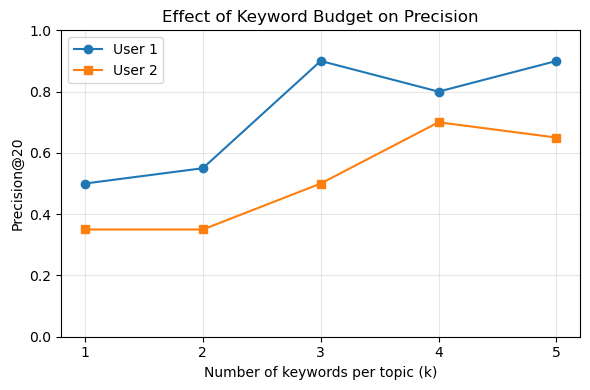

In [25]:
# utility dictionaries to store data for accessing.
top_n = 20
topic_raw = {
    "dark":       dark_raw,
    "sadness":    sadness_raw,
    "personal":   personal_raw,
    "lifestyle":  lifestyle_raw,
    "emotion":    emotion_raw,
}
songs_test = {
    "dark":       q3test,
    "sadness":    q3test,
    "personal":   q3test,
    "lifestyle":  q3test,
    "emotion":    q3test,
}

user_kw_full = {
    "user1": {
        "dark":       user1_dark_kw_str,
        "sadness":    user1_sadness_kw_str,
        "personal":   user1_personal_kw_str,
        "lifestyle":  user1_lifestyle_kw_str,
        "emotion":    user1_emotion_kw_str,
    },
    "user2": {
        "sadness":    user2_sadness_kw_str,
        "emotion":    user2_emotion_kw_str,
    },
}

# Build a mean TF-IDF profile from the first k keywords
def build_profile(raw_docs, kw_list, k):
    sel = [preprocess_text(w) for w in kw_list[:k]]
    matched = [doc for doc in raw_docs if any(kw in doc for kw in sel)]
    if not matched:
        return np.zeros((len(q2vectorizer.vocabulary_),))
    vec = q2vectorizer.transform(" ".join(matched).splitlines()).mean(axis=0)
    return np.asarray(vec).ravel()

# Run keyword-budget experiment for each user
precisions = {"user1": [], "user2": []}
for uname, kw_dict in user_kw_full.items():
    print(f"\n====== {uname.upper()} ======")
    for k in range(1, 6):                       # 1 … 5 keywords/topic
        # Build per-topic TF-IDF profiles (only topics user has)
        profiles = {
            t: build_profile(topic_raw[t], kw_dict[t], k)
            for t in kw_dict
        }

        # Assemble candidate list across topics
        merged_songs, merged_scores, merged_kws = [], np.empty(0), []
        for t in kw_dict:
            sims = compute_similarity_dict(songs_test[t], profiles[t])["jaccard"]
            ranked_songs, ranked_scores = rank_songs(songs_test[t], sims)
            merged_songs.extend(ranked_songs)
            merged_scores = np.concatenate([merged_scores, ranked_scores])
            merged_kws.extend([kw_dict[t][:k]] * len(ranked_songs))

        # Select overall top-N
        top_songs, _, top_kw = get_top_n_songs(merged_songs,
                                               merged_scores,
                                               merged_kws,
                                               topn=top_n)

        # Metrics
        prec  = get_top_N_precision(top_songs, top_kw)
        precisions[uname].append(prec) 
        cgain = get_cum_gain(top_songs, top_kw)
        print(f"[k={k}]  Precision@{top_n}: {prec:.3f}   |   Cum.Gain: {cgain}")

import matplotlib.pyplot as plt

ks = range(1, 6)
plt.figure(figsize=(6, 4))
plt.plot(ks, precisions["user1"], marker='o', label='User 1')
plt.plot(ks, precisions["user2"], marker='s', label='User 2')
plt.xlabel('Number of keywords per topic (k)')
plt.ylabel(f'Precision@{top_n}')
plt.title('Effect of Keyword Budget on Precision')
plt.xticks(ks)
plt.ylim(0, 1)            # optional: fix y-axis to [0, 1]
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Explaining the differences between users:

We found that User 1 >> User 2 =(roughly) User 3.

User 1 supplies five distinct topics, each described by five carefully chosen keywords, whereas User 2 provides only two such topic-keyword sets. Because the recommender draws the same overall **Top-N** list for every user, it must allocate those N slots across the topics available. With five topics, User 1 needs, on average, only the two best-scoring songs per topic to fill the list (N ÷ 5 ≈ 2), while User 2 must take roughly the five best songs from each of just two topics (N ÷ 2 = 5). A stricter cut-off within each topic means the songs that survive for User 1 come from deeper competition and therefore tend to have higher similarity scores. Put differently, expanding the number of topics widens the candidate pool without increasing the quota of final recommendations, so the average similarity threshold for inclusion rises.

User 2 being about even in performance over user 3 can be explained by the above discussion, where having more words was found to have a significant impact. User 2 has 10 words in total, 5 each, whilst user 3 has 8 words across 3 classes, averaging 2.6 words/class. However, the addition for an additional class does bring the benefits of a wider pool of candidates to choose from as discussed above, and the difference in keywords is not massive. This explains why User 2 and 3 have statistically insignificant differences.

# Part 3

In [26]:
import pandas as pd

#load dataset for question 3
df3 = pd.read_csv('dataset.tsv', sep='\t')
df3['content'] = (
    df3['artist_name'].astype(str) + " "
    + df3['track_name'].astype(str) + " "
    + df3['genre'] + " "
    + df3['lyrics']
)
# generate N songs per batch
weeks = [df3['content'][i:i+250] for i in range(0, 1000, 250)]
samples = [wk.sample(n=10, random_state=42) for wk in weeks]
def print_week(sample_series, label):
    print(f"\n{label}:")
    for pos, (orig_idx, song) in enumerate(sample_series.items(), start=1):
        print(f"{pos:>2}. [idx {orig_idx}] {song}")

print_week(samples[0], "Week 1 Sample")
print_week(samples[1], "Week 2 Sample")
print_week(samples[2], "Week 3 Sample")



Week 1 Sample:
 1. [idx 142] skool 77 vivo hip hop (live) hip hop head camden sure raise toast patron saint waifs stray bingham ghost freshfaced lass kentish come people pedlars bingham husband camden coach house till hang neck tyburn tree steal sheep break heart lose child name take hand meek mild drinker thinker daily bring wife tear camden winter morning simply disappear head camden sure raise toast patron saint waifs stray bingham ghost earn reputation bitter camden streets tarry bingham girl hold manhood cheap miser pitcher lips till night check oven burn crisp try murder think finally cook die slip noose fugitive justice take beat poison head camden sure raise toast patron saint waifs stray bingham ghost locals like false word follow call wicked woman sorceress renown swear gravestones husband grow ribald righteous know witch reason hat simple kindness careless take need guilty gamblers harlots  know offer sanctuary judgement judge fall die swear devil break door chair body pry 

In [27]:
# manual selection of songs from weeks 1 - 3 by index made by user.
selected_index = [60, 112, 197, 104, 256, 431, 354, 642, 506]

# preprocess the selected songs, and sort them by topic.
selected_songs = df3['content'].iloc[selected_index].tolist()
selected_songs_preprocessed = [preprocess_text(song) for song in selected_songs]
predictions = svm_model.predict(selected_songs_preprocessed)

# collect data structures
all_topics = ["dark", "sadness", "personal", "lifestyle", "emotion"]
topic_samples = {t: [] for t in all_topics}

for song, pred in zip(selected_songs, predictions):
    topic_samples[pred].append(song)          # assign to its topic

# mark empty topics explicitly as None
for t in all_topics:
    if not topic_samples[t]:
        topic_samples[t] = None

# create a vector for each topic
topic_profiles = {}
for t, lst in topic_samples.items():
    if lst is None:
        topic_profiles[t] = None
    else:
        vec = q2vectorizer.transform([preprocess_text(s) for s in lst]).mean(axis=0)
        topic_profiles[t] = np.asarray(vec).ravel()    

week4_raw   = df3['content'][750:1000].tolist()          # 250 songs
week4_array = np.array(week4_raw)

merged_songs  = []
merged_scores = np.empty(0)

# for each topic, compute similarity scores and rank songs
for t, profile in topic_profiles.items():
    if profile is None:
        continue
    
    sims = compute_similarity_dict(week4_array, profile)["jaccard"]  # (250,1)
    ranked_songs, ranked_scores = rank_songs(week4_raw, sims)
    merged_songs.extend(ranked_songs)
    merged_scores = np.concatenate([merged_scores, ranked_scores.flatten()])

# keep best rank for each song.
best = {}
for song, score in zip(merged_songs, merged_scores):
    if song not in best or score > best[song]:
        best[song] = score

#sort by top10.
top10 = sorted(best.items(), key=lambda x: x[1], reverse=True)[:10]

#print.
print("\n=== Topic assignment of the 10 sampled songs ===")
for t in all_topics:
    print(f"{t:<10s}: {len(topic_samples[t]) if topic_samples[t] else 0}")

print("\n=== Top-10 Week-4 recommendations (Jaccard) ===")
for i, (song, score) in enumerate(top10, 1):
    print(f"{i:>2}.  {score:.4f}  {song[:120]}…")   # truncate long lyrics




=== Topic assignment of the 10 sampled songs ===
dark      : 5
sadness   : 1
personal  : 0
lifestyle : 3
emotion   : 0

=== Top-10 Week-4 recommendations (Jaccard) ===
 1.  0.5195  yoke lore truly madly deeply pop dream wish fantasy need breath truly madly deeply strong faithful cause count begin rea…
 2.  0.5108  daniel caesar we find love pop anymore like song walk door wonder take long know girl dream anymore like song fall fall …
 3.  0.4826  hellyeah love falls rock cry sleep felt incomplete deep bleed feel want feel need feel like hang thread rope noose neck …
 4.  0.4330  wolfmother baroness blues live peasantry live higher class sleep mansion sleep grass come darkness baroness tonight toni…
 5.  0.4218  nai palm crossfire / so into you jazz crossfire fall fall fall fall defend good define give time crossroad better crossf…
 6.  0.3937  nicole henry moon river jazz put word mouth know troublin gonna know hear loud stop deserve tell deserve hear word come …
 7.  0.3615  keith ur

In [28]:
# manual input of user likes.
likes = [1, 4, 6]
likes_size   = len(likes)
precision10  = likes_size / 10          # Precision@10
cum_gain     = likes_size               # Cumulative gain

# Print in table format
metrics_df = pd.DataFrame({
    "Metric": ["Precision@10", "Cumulative Gain"],
    "Value":  [precision10,     cum_gain]
})

print(metrics_df.to_string(index=False))

         Metric  Value
   Precision@10    0.3
Cumulative Gain    3.0


In reality, talking to the user, it was clear that the recommendation system was very disconnected from reality. This reflects in the precision rate (30%) - which was low compared to “theoretical" experiments. 

The user mostly evaluated the songs by these criteria: the lyrics making sense / intuitively resonating within the first ~20 words, the user did not like songs that were obviously too dark (e.g. "blood blood death ..."), and the user liked the songs that sounded like potential rave music. 

One discrepancy between the recommender and the real-world use is that songs are rarely evaluated by their lyrics on the first-listen. Through a text-only model, key parts of what makes a song appealing (rhythm, tune) are missing. This makes it very difficult for a user to evaluate whether they "like" a song.

Additionally, the recommender finds the "similarity" of a song by vectorizing it's entire contents. However, when evaluating song on a purely textual-based method, users do not want to read through the entire song and instead choosing to just look at the first few words. This is not helped by how most songs are designed to work best with their musical elements, and not as standalone literature pieces to read. 

Overall, the recommendations were considered "poor" by the user, but the user attributes this rating mostly to it being difficult to differentiate song features purely based on the first few words, which are often written in "poor" english grammar. 

Perhaps the main criticism is that this recommender system attempts to find patterns for human behaviour which are simply not relevant in the real world.